# Funding-Rate and Basis Arbitrage Analysis

This notebook builds a simple perpetual futures basis process and tests a threshold-based delta-neutral carry strategy:
- Long spot / short perp when annualized basis is rich
- Flat otherwise
- PnL decomposition into funding carry, basis convergence, and transaction cost

## Workflow

1. Ensure `outputs/baseline_mm_result.json` exists (`make report`).
2. Use baseline mid as a spot proxy.
3. Run the synthetic basis process and strategy simulation.

In [6]:
from __future__ import annotations

import json
import math
import random
from pathlib import Path

import matplotlib.pyplot as plt

# Load baseline spot proxy from simulation output.
result_path = Path('../outputs/baseline_mm_result.json')
if not result_path.exists():
    raise FileNotFoundError('Missing outputs/baseline_mm_result.json. Run `make report` first.')

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

spot = payload['series']['mid']
n = len(spot)
n

2500

## 1) Synthetic basis construction

Annualized basis follows a bounded mean-reverting process to create realistic (but stylized) carry opportunities.

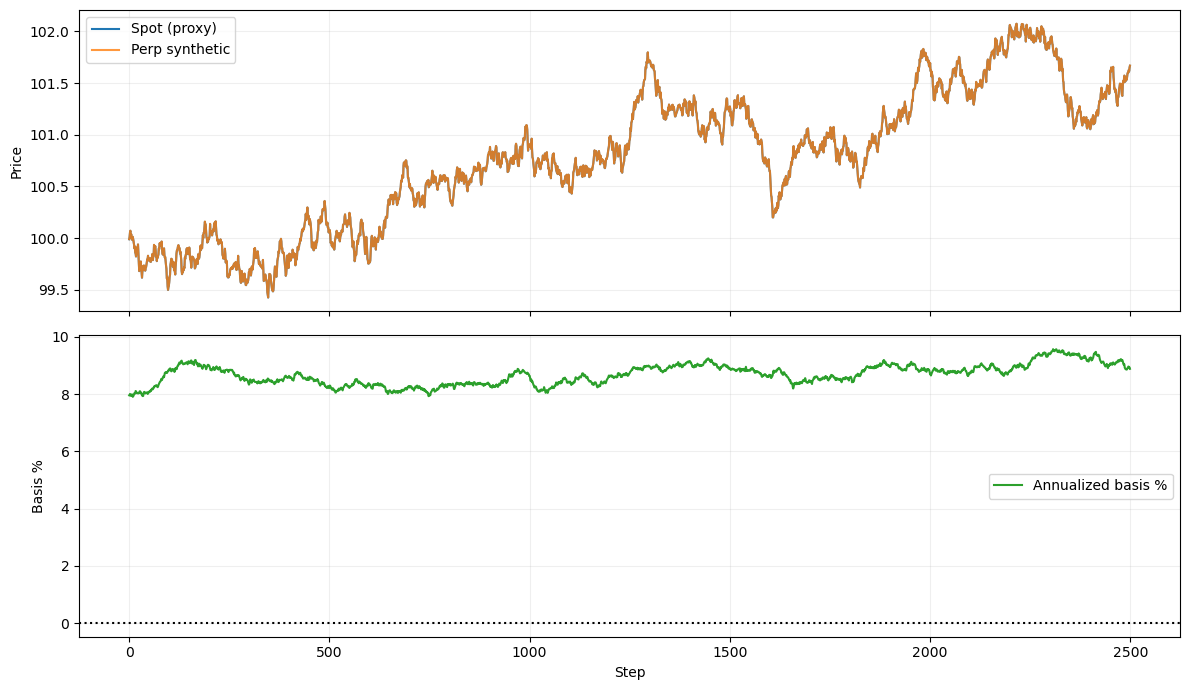

In [7]:
# Synthetic basis process (annualized), mean-reverting around 0.
rng = random.Random(11)
dt = 1.0 / (365.0 * 24.0 * 60.0)  # 1 step ~ 1 minute
kappa = 12.0
basis_vol = 0.25
basis = []
b = 0.08  # start: 8% annualized
for _ in range(n):
    shock = rng.gauss(0.0, basis_vol * math.sqrt(dt))
    b += -kappa * b * dt + shock
    b = max(-0.30, min(0.30, b))
    basis.append(b)

perp = [s * (1.0 + b / 365.0 / 24.0) for s, b in zip(spot, basis)]

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(spot, label='Spot (proxy)', color='tab:blue')
ax[0].plot(perp, label='Perp synthetic', color='tab:orange', alpha=0.8)
ax[0].set_ylabel('Price')
ax[0].legend()
ax[0].grid(alpha=0.2)

ax[1].plot([100.0 * x for x in basis], label='Annualized basis %', color='tab:green')
ax[1].axhline(0.0, color='black', linestyle=':')
ax[1].set_ylabel('Basis %')
ax[1].set_xlabel('Step')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

## 2) Strategy logic

Entry/exit is threshold-based on annualized basis. The strategy is delta-neutral in spirit: long spot, short perp when basis is rich.

In [8]:
# Strategy: enter carry trade when basis is above threshold.
entry_threshold = 0.05  # 5% annualized
exit_threshold = 0.01   # 1% annualized
notional_usd = 10_000.0
fee_bps_per_leg = 2.0

position = 0  # 0 flat, 1 long spot / short perp
qty = 0.0
total_cost = 0.0
carry_pnl = 0.0
basis_pnl = 0.0
trades = 0

equity = []
inv_state = []
carry_path = []
basis_path = []
cost_path = []

for t in range(1, n):
    s0, s1 = spot[t - 1], spot[t]
    p0, p1 = perp[t - 1], perp[t]
    b0 = basis[t - 1]

    if position == 0 and b0 >= entry_threshold:
        qty = notional_usd / max(s0, 1e-9)
        trade_notional = qty * s0 + qty * p0
        cost = trade_notional * (fee_bps_per_leg / 10_000.0)
        total_cost += cost
        trades += 1
        position = 1

    elif position == 1 and b0 <= exit_threshold:
        trade_notional = qty * s0 + qty * p0
        cost = trade_notional * (fee_bps_per_leg / 10_000.0)
        total_cost += cost
        trades += 1
        position = 0
        qty = 0.0

    step_carry = 0.0
    step_basis = 0.0
    if position == 1:
        # Funding carry approximation on short perp leg.
        step_carry = (notional_usd * b0) * dt

        # Delta-neutral spread convergence component (long spot, short perp).
        spread0 = p0 - s0
        spread1 = p1 - s1
        step_basis = -qty * (spread1 - spread0)

    carry_pnl += step_carry
    basis_pnl += step_basis

    eq = carry_pnl + basis_pnl - total_cost
    equity.append(eq)
    inv_state.append(position)
    carry_path.append(carry_pnl)
    basis_path.append(basis_pnl)
    cost_path.append(total_cost)

In [9]:
final_pnl = equity[-1] if equity else 0.0
exposure_ratio = sum(inv_state) / len(inv_state) if inv_state else 0.0

print('trades:', trades)
print('time_in_trade_ratio:', round(exposure_ratio, 4))
print('carry_pnl:', round(carry_pnl, 4))
print('basis_pnl:', round(basis_pnl, 4))
print('transaction_cost:', round(total_cost, 4))
print('final_pnl:', round(final_pnl, 4))

trades: 1
time_in_trade_ratio: 1.0
carry_pnl: 4.1281
basis_pnl: -0.0123
transaction_cost: 4.0
final_pnl: 0.1158


## 3) Decomposition and exposure

The plots separate carry, basis convergence, and costs so you can diagnose if profitability is structural or parameter-dependent.

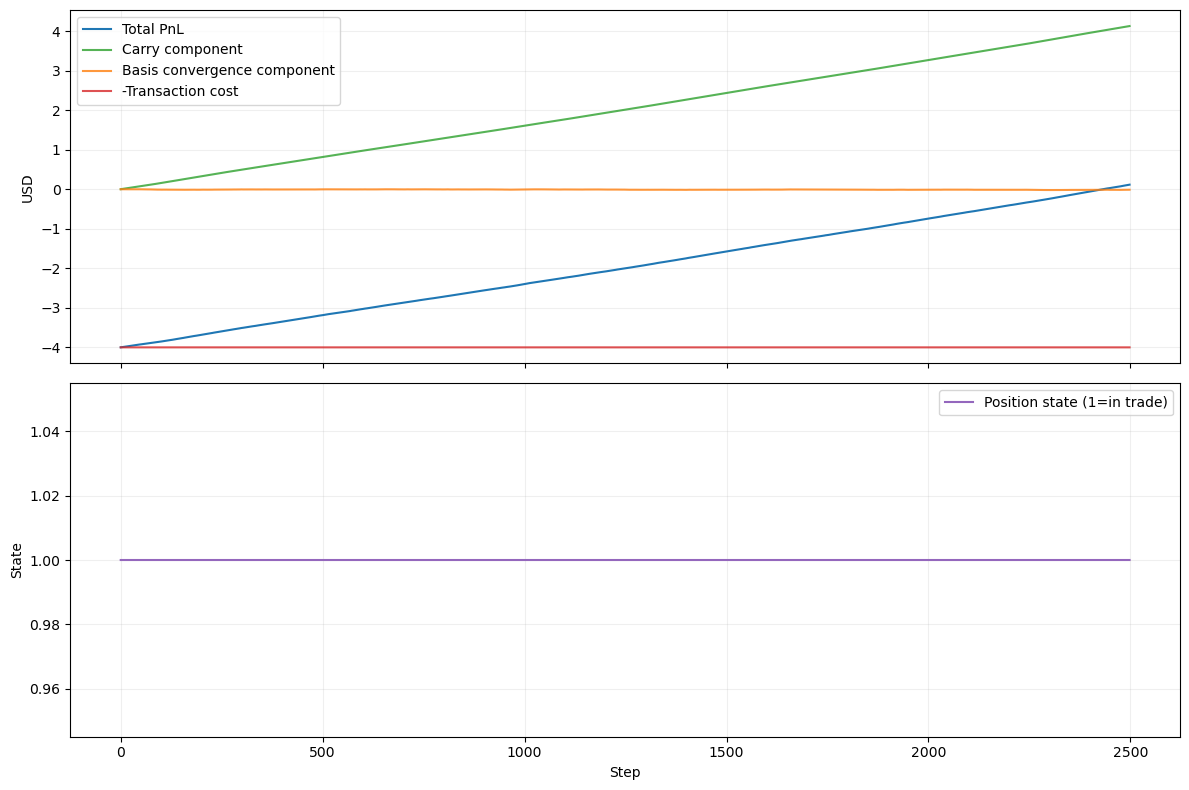

In [10]:
x = list(range(len(equity)))

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(x, equity, label='Total PnL', color='tab:blue')
ax[0].plot(x, carry_path, label='Carry component', color='tab:green', alpha=0.8)
ax[0].plot(x, basis_path, label='Basis convergence component', color='tab:orange', alpha=0.8)
ax[0].plot(x, [-c for c in cost_path], label='-Transaction cost', color='tab:red', alpha=0.8)
ax[0].set_ylabel('USD')
ax[0].legend()
ax[0].grid(alpha=0.2)

ax[1].plot(x, inv_state, label='Position state (1=in trade)', color='tab:purple')
ax[1].set_ylabel('State')
ax[1].set_xlabel('Step')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Notes

This is a compact interview-style model, not a production backtest. To make it production-grade:
- model exchange-specific funding intervals and caps
- add borrow/funding constraints and transfer latency
- include execution impact and partial fills on both legs
- calibrate basis dynamics from real perp and index data